# Image Processing Assignment : Road Network Detection 

- Name: Subhrajyoty Roy
- Roll : MB1911
- Subject : Signal and Image Processing
- Date: 8th January, 2021


## Importing Necessary Packages

We first start by importing necessary packages for reading and viewing images, as well as the linear algebra library to perform fast calculations.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from sklearn.metrics import jaccard_score
from scipy.ndimage import convolve, median_filter

## Introduction

Detecting road networks from satelite image is an extremely useful and important task. In this assignment, we shall try to use different algorithms to obtain the predicted road networks from the satelite image. For computational and demonstration purpose, we shall use only one satelite image. Later, the algorithms will be run on each of the images separately to provide the output.

In [6]:
img = mpimg.imread('./images/6100_1_3_RGB.jpg')
mask = mpimg.imread('./images/6100_1_3_MASK.png')

In [7]:
img.shape

(3349, 3349, 3)

As it can be seen that the image has very high resolution, hence we crop to the first 200 pixels to speed up the demonstration process. The satelite image is as follows.

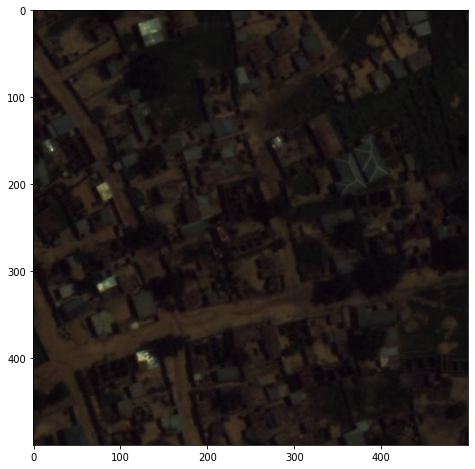

In [8]:
# crop the image and mask

img = img[:500, :500, :]
fig = plt.figure(figsize = (8, 8))
plt.imshow(img)
plt.show()

The corresponding ground truth image is as follows.

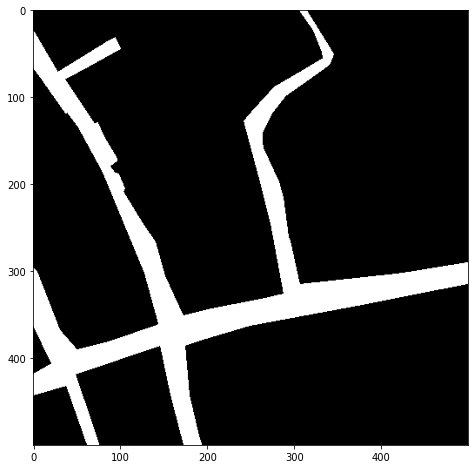

In [9]:
mask = mask[:500, :500]
fig = plt.figure(figsize = (8, 8))
plt.imshow(mask, cmap = 'gray')
plt.show()

## Preprocessing

Since, the satelite image provides a view of the area at night times, some image enhancement techniques should be applied in order to obtain better contrast of the image. Let us take a look at the histogram of pixel intensity values in each of the red, green and blue channel of the cropped image.

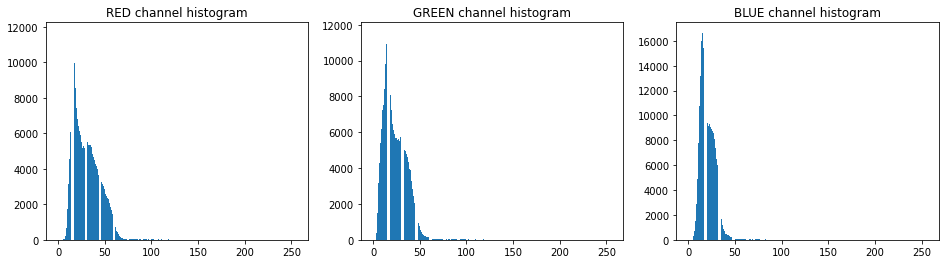

In [10]:
# let's look at the histograms
red_vals = np.zeros(256)
green_vals = np.zeros(256)
blue_vals = np.zeros(256)

for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        red_vals[img[i, j, 0]] += 1
        green_vals[img[i, j, 1]] += 1
        blue_vals[img[i, j, 2]] += 1
        
fig, ax = plt.subplots(1, 3, figsize = (16, 4))
ax[0].bar(np.arange(0, 256), red_vals)
ax[0].set_title('RED channel histogram')

ax[1].bar(np.arange(0, 256), green_vals)
ax[1].set_title('GREEN channel histogram')

ax[2].bar(np.arange(0, 256), blue_vals)
ax[2].set_title('BLUE channel histogram')

plt.show()

Clearly, the histograms in all three channels mostly squeeze between 0 and 50. Therefore, we apply histogram stretching technique to spread the histogram over the range [0, 255] so that the distribution of the pixel instensities is more flat. This should result in an image with better constrast and visibility.

In [11]:
# So, apply histogram streching scheme
def enhance_image(img):
    red_vals = np.zeros(256)
    green_vals = np.zeros(256)
    blue_vals = np.zeros(256)

    # find intensity frequencies
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            red_vals[img[i, j, 0]] += 1
            green_vals[img[i, j, 1]] += 1
            blue_vals[img[i, j, 2]] += 1
            
    # find cumulative sums
    red_cdf = np.cumsum(red_vals)
    green_cdf = np.cumsum(green_vals)
    blue_cdf = np.cumsum(blue_vals)
    
    h_red = (red_cdf - min(red_cdf)) / (img.shape[0] * img.shape[1] - min(red_cdf)) * 255
    h_green = (green_cdf - min(green_cdf)) / (img.shape[0] * img.shape[1] - min(green_cdf)) * 255
    h_blue = (blue_cdf - min(blue_cdf)) / (img.shape[0] * img.shape[1] - min(blue_cdf)) * 255
    
    # create new equalized image
    new_img = np.zeros(img.shape)
    new_img[:, :, 0] = h_red[img[:, :, 0]]
    new_img[:, :, 1] = h_green[img[:, :, 1]]
    new_img[:, :, 2] = h_blue[img[:, :, 2]]
    
    return np.array(np.round(new_img), dtype = 'uint8')

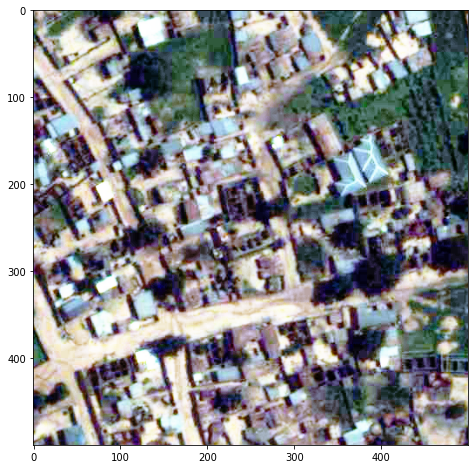

Wall time: 984 ms


In [12]:
%%time
new_img = enhance_image(img)
fig = plt.figure(figsize = (8, 8))
plt.imshow(np.array(new_img, dtype = 'uint8'))
plt.show()

In [14]:
import cv2
cv2.imwrite('img.jpg', new_img)

True

As one can see, the satelite image is now more prominent, with a better visibility of the roads and the greeneries and the buildings. Now, we proceed to our first approach to detect the road networks.


## Algorithm 1: kMeans

kMeans is an unsupervised algorithm for clustering. Since only the satelite image is provided and we do not use any landmark points, then unsupervised setup is evident as there is no training label. So, we use kMeans to cluster the [R, G, B] color values that appear in the above image.

In [87]:
from sklearn.cluster import KMeans

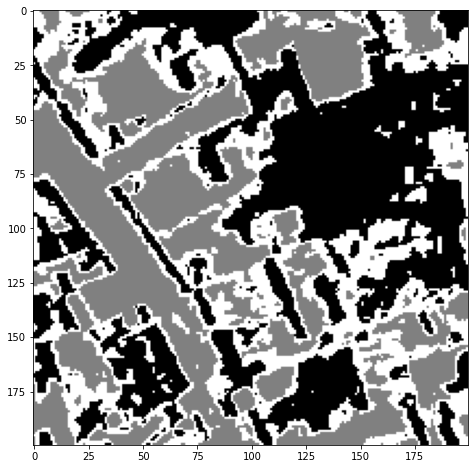

In [88]:
X = new_img.reshape(-1, 3)
model = KMeans(n_clusters=3, random_state=1911).fit(X)
preds = model.labels_.reshape(mask.shape)
fig = plt.figure(figsize = (8, 8))
plt.imshow(100 * np.array(preds, dtype = 'uint8'), cmap = 'gray')
plt.show()

We used 3 clusters corresponding to 

1. Buildings.
2. Forest, Vegetation and Trees.
3. Roads.

Let us see the cluster centers to see if that is the case. As shown above, the main road is very accurately detected using kMeans. However, since there are 3 clusters, now we need to determine which clusters corresponds to the roads. For example, in the above result, the gray color corresponds to the roads. Since the roads are usually grey / whitish in colour, we shall consider the cluster corresponding to the white colour [255, 255, 255] as the cluster corresponding to the road. Using that, we detect the road network of the image.

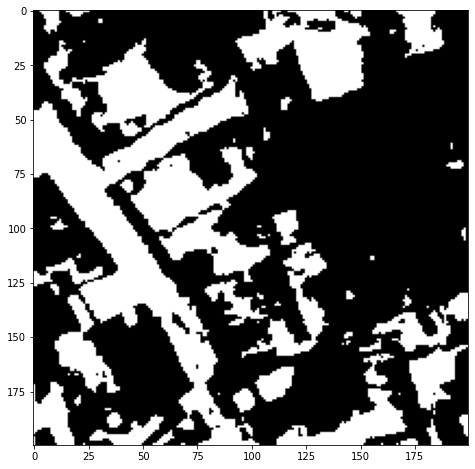

In [89]:
road_cluster = model.predict([[255, 255, 255]])[0]
preds = np.array(preds == road_cluster, dtype = 'uint8')

fig = plt.figure(figsize = (8, 8))
plt.imshow(preds, cmap = 'gray')
plt.show()

As we see, the prediction can detect the road, however, it comes up with lots of disconnected components which does not necessarily corresponds to a road. We can use the jaccard metric to evaluate the performance.

In [90]:
jaccard_score(mask.reshape(-1), preds.reshape(-1))

0.24165810208975677

We see that we have only 24% accuracy in Jaccard score, which is quite low.

## Algorithm 2 : Flood Filling

Since, the unsupervised approach does not perform good, a supervised approach is used here. In this algorithm, we choose certain landmark points from the outer edge of the true mask, i.e. the very top, very bottom, left and right borders of the image. Also as roads are connected with each other, a flood filling algorithm is used from that landmark points to cover the pixels corresponding to the roads. 

Before, that, we need to perform an edge detection technique to detect the regions of the image. Here, we use the Sobel filters to detect these edges, and consider the magnitude of such filter across all channels. 

In [100]:
def detect_edges(img):
    Gx = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
    Gy = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

    tmp = np.zeros(img.shape)

    for i in range(3):
        # do a median smoothing
        tmp[:, :, i] = median_filter(img[:, :, i], size = 3)
        
        # apply sobel operators for edge detection
        xdiff = convolve(tmp[:, :, i], Gx)
        ydiff = convolve(tmp[:, :, i], Gy)
        tmp[:, :, i] = (xdiff**2 + ydiff**2)**0.5
        tmp[:, :, i] = np.round(tmp[:, :, i])
        
    tmp = tmp.max(axis = 2)  # take maximum magnitude along the channels
    return 255 * np.array(tmp > tmp.mean(), dtype = 'uint8')

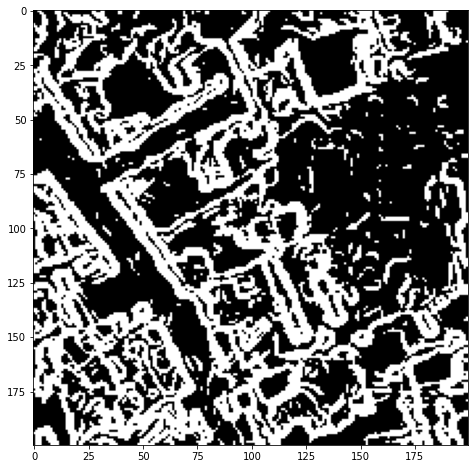

In [101]:
edges = detect_edges(new_img)
fig = plt.figure(figsize = (8, 8))
plt.imshow(edges, cmap = 'gray')
plt.show()

As we see above, there are many edges in the picture. There are edges corresponding to buildings, which are very short in length, and the longer edges corresponds to the roads. Next, we apply the flood filling algorithm. 

To implement the flood filling algorithm, we shall use 4-connectivity to draw the connected regions. We also implement the algorithm using a queue to make the implementation faster.

In [102]:
from queue import Queue

# flood filling algorithm
def flood_fill(input_matrix, node, target_color, replacement_color):
    matrix = np.copy(input_matrix)
    if target_color == replacement_color:
        return (matrix, None)
    if matrix[node[0], node[1]] != target_color:
        return (matrix, 0)
    matrix[node[0], node[1]] == replacement_color
    queue_x = Queue()
    queue_y = Queue()
    queue_x.put_nowait(node[0])
    queue_y.put_nowait(node[1])
    
    while not queue_x.empty():
        n = [queue_x.get_nowait(), queue_y.get_nowait()]
        if n[0] > 0:
            if matrix[n[0]-1, n[1]] == target_color:
                matrix[n[0]-1, n[1]] = replacement_color
                queue_x.put_nowait(n[0] - 1)
                queue_y.put_nowait(n[1])
        if n[0] < (matrix.shape[0] - 1):
            if matrix[n[0]+1, n[1]] == target_color:
                matrix[n[0]+1, n[1]] = replacement_color
                queue_x.put_nowait(n[0] + 1)
                queue_y.put_nowait(n[1])
        if n[1] > 1:
            if matrix[n[0], n[1]-1] == target_color:
                matrix[n[0], n[1]-1] = replacement_color
                queue_x.put_nowait(n[0])
                queue_y.put_nowait(n[1] - 1)
        if n[1] < (matrix.shape[1] - 1):
            if matrix[n[0], n[1] + 1] == target_color:
                matrix[n[0], n[1] + 1] = replacement_color
                queue_x.put_nowait(n[0])
                queue_y.put_nowait(n[1] + 1)
    
    return matrix


# this algorithm uses the landmark points in the mask and then apply the floodfilling algorithm to the edge matrix 
def detect_roads_using_floodfill(edges, mask):
    preds = np.zeros(mask.shape)
    visited = np.zeros(mask.shape)

    # go along the top row first
    for j in range(0, mask.shape[1]):
        if mask[0, j] == 1 and not visited[0, j]:
            tmp = flood_fill(edges, [0, j], 0, 100)
            visited[tmp == 100] = True
            preds[tmp == 100] = 1
            
    # go along the bottom row next
    for j in range(0, mask.shape[1]):
        if mask[mask.shape[0]-1, j] == 1 and not visited[mask.shape[0]-1, j]:
            tmp = flood_fill(edges, [mask.shape[0]-1, j], 0, 100)
            visited[tmp == 100] = True
            preds[tmp == 100] = 1
            
    # go along the left row
    for i in range(1, mask.shape[0]-1):
        if mask[i, 0] == 1 and not visited[i, 0]:
            tmp = flood_fill(edges, [i, 0], 0, 100)
            visited[tmp == 100] = True
            preds[tmp == 100] = 1
    
    # go along the right row
    for i in range(1, mask.shape[0]-1):
        if mask[i, mask.shape[1] - 1] == 1 and not visited[i, mask.shape[1] - 1]:
            tmp = flood_fill(edges, [i, mask.shape[1] - 1], 0, 100)
            visited[tmp == 100] = True
            preds[tmp == 100] = 1
    
    return preds

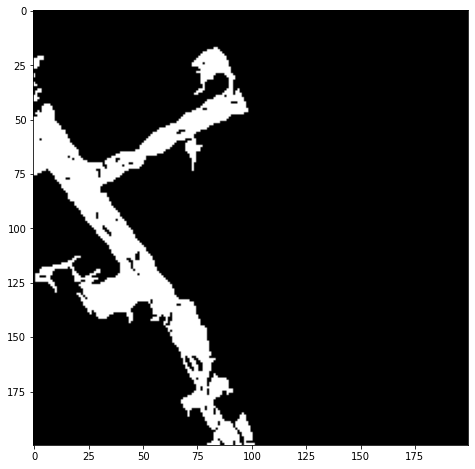

In [103]:
preds = detect_roads_using_floodfill(edges, mask)
fig = plt.figure(figsize = (8, 8))
plt.imshow(preds, cmap = 'gray')
plt.show()

The predicted road network is now better than the one we obtained using kMeans. The jaccard score is now about 54%.

In [104]:
jaccard_score(mask.reshape(-1), preds.reshape(-1))

0.5472889980698368

## Evaluation

Now, we apply these two algorithms on all of the available satelite images. The following helper function does the job.

In [115]:
from IPython.display import clear_output

def extract_road_networks(img_name, BATCH_SIZE = 279):
    img = mpimg.imread('./images/' + img_name + '_RGB.jpg')   # read the image and the mask from the path
    mask = mpimg.imread('./images/' + img_name + '_MASK.png')
    
    n_batch = int(img.shape[0] / BATCH_SIZE)
    
    # apply the contrast enhancement first
    img = enhance_image(img)
    plt.imsave('./outputs/' + img_name + '_Enhanced.png', img)
    print('Saved enhanced image...\n')
    
    pred_img1 = np.zeros((img.shape[0], img.shape[1]))  # prediction from kMeans
    pred_img2 = np.zeros((img.shape[0], img.shape[1]))  # prediction from Flood filling
    
    for bx in range(0, n_batch):
        for by in range(0, n_batch):
            print('Working on Region ', (bx + 1, by + 1), ' out of ', (n_batch, n_batch))
            subimg = img[(bx * BATCH_SIZE):((bx + 1) * BATCH_SIZE), (by * BATCH_SIZE):((by + 1) * BATCH_SIZE)]
            submask = mask[(bx * BATCH_SIZE):((bx + 1) * BATCH_SIZE), (by * BATCH_SIZE):((by + 1) * BATCH_SIZE)]
            
            # apply Kmeans
            X = subimg.reshape(-1, 3)
            model = KMeans(n_clusters=3, random_state=1911).fit(X)
            preds = model.labels_.reshape(submask.shape)
            road_cluster = model.predict([[255, 255, 255]])[0]
            preds = np.array(preds == road_cluster, dtype = 'uint8')
            pred_img1[(bx * BATCH_SIZE):((bx + 1) * BATCH_SIZE), (by * BATCH_SIZE):((by + 1) * BATCH_SIZE)] = preds
            
            # apply flood filling
            edges = detect_edges(subimg)
            preds = detect_roads_using_floodfill(edges, submask)
            pred_img2[(bx * BATCH_SIZE):((bx + 1) * BATCH_SIZE), (by * BATCH_SIZE):((by + 1) * BATCH_SIZE)] = preds
            
            # print a progress bar
            print('Region ', (bx + 1, by + 1), ' out of ', (n_batch, n_batch))
            clear_output(wait = True)
            
    
    plt.imsave('./outputs/' + img_name + '_Pred_KMeans.png', pred_img1)
    plt.imsave('./outputs/' + img_name + '_Pred_Floodfill.png', pred_img2)
    
    # print the jaccard evaluation metric
    print('Jaccard score (KMeans) : ', jaccard_score(mask.reshape(-1), pred_img1.reshape(-1)) )
    print('Jaccard score (Floodfill) : ', jaccard_score(mask.reshape(-1), pred_img2.reshape(-1)) )

In [113]:
extract_road_networks('6100_1_3')

Jaccard score (KMeans) :  0.1708539740686913
Jaccard score (Floodfill) :  0.22041323489356984


In [116]:
extract_road_networks('6110_4_0')

Jaccard score (KMeans) :  0.03365850730037063
Jaccard score (Floodfill) :  0.11870480051915701


In [117]:
extract_road_networks('6120_2_0')

Jaccard score (KMeans) :  0.05362059745635693
Jaccard score (Floodfill) :  0.1030662418177561


In [118]:
extract_road_networks('6120_2_2')

Jaccard score (KMeans) :  0.1336221377488217
Jaccard score (Floodfill) :  0.16359736508712966


In [119]:
extract_road_networks('6140_3_1')

Jaccard score (KMeans) :  0.04191702344546381
Jaccard score (Floodfill) :  0.1787433840826447


As seen from the results, the floodfilling algorithm performs better than the kMeans algorithm in detection of the road network.